In [1]:
from copy import deepcopy

import torch
import pytorch_lightning as pl
import numpy as np

from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf

from ens_transformer.data_module import IFSERADataModule

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as mpl_gs
import matplotlib.colors as mpl_c

In [2]:
plt.style.use('paper')
plt.style.use('egu_journals')

In [3]:
pl.seed_everything(42)

Global seed set to 42


42

In [4]:
with initialize(config_path="../data/models/transformer_scale/transformer_5_20/hydra"):
    cfg = compose('config.yaml')

In [5]:
ens_net = instantiate(
    cfg.model,
    in_channels=len(cfg.data.include_vars),
    learning_rate=cfg.learning_rate
)
ens_net = ens_net.load_from_checkpoint("../data/models/transformer_scale/transformer_5_20/last.ckpt", map_location=torch.device('cpu'))

In [6]:
data_module = instantiate(cfg['data']['data_module'], pin_memory=False)
data_module.setup()

In [7]:
ifs_data = data_module.ds_test.input_transform(data_module.ds_test.ifs.sel(time='2019-09-01 12:00').values)[None, :]

In [8]:
with torch.no_grad():
    predicted_data = ens_net(ifs_data)

In [9]:
ifs_perts = (ifs_data[:, :, 0] - ifs_data[:, :, 0].mean(dim=1)).squeeze()
predicted_perts = (predicted_data - predicted_data.mean(dim=1)).squeeze()

# Dorian position

26.6N 77.2W

In [10]:
i_lat = 20
i_lon = 50

In [11]:
ifs_covariance = torch.einsum('ihw,i->hw', ifs_perts, ifs_perts[:, i_lat, i_lon]) / 49
pred_covariance = torch.einsum('ihw,i->hw', predicted_perts, predicted_perts[:, i_lat, i_lon]) / 49

In [12]:
ifs_corr = ifs_covariance / ifs_perts.std(dim=0) / ifs_perts[:, i_lat, i_lon].std(dim=0)
pred_corr = pred_covariance / predicted_perts.std(dim=0) / predicted_perts[:, i_lat, i_lon].std(dim=0)

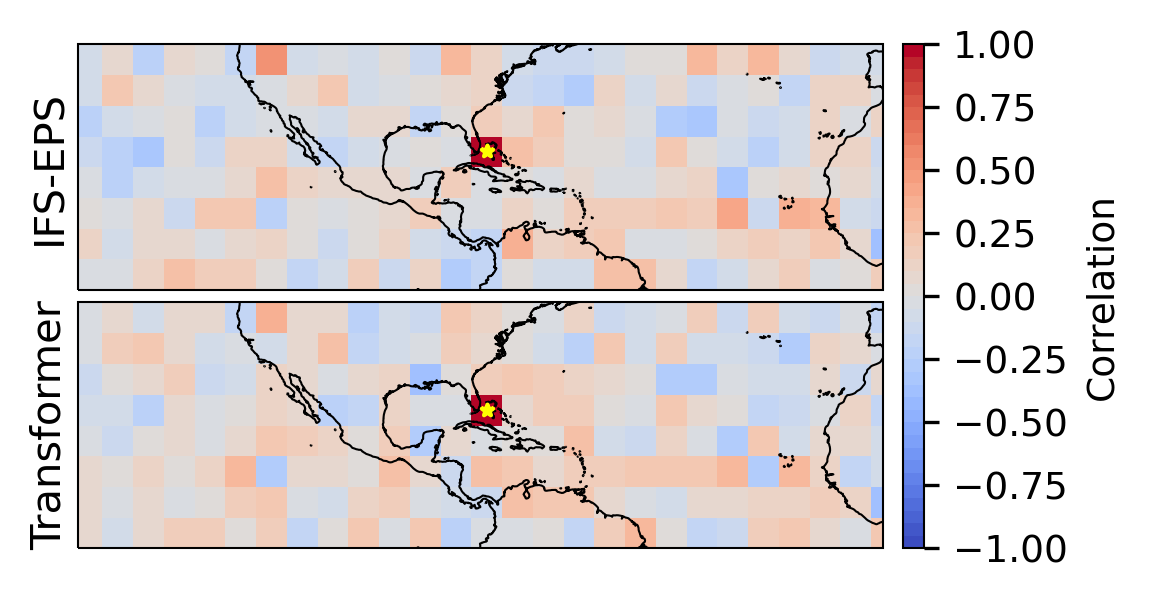

In [14]:
gs = mpl_gs.GridSpec(nrows=2, ncols=21, wspace=1)
cmap = plt.get_cmap('coolwarm')
norm = mpl_c.BoundaryNorm(np.linspace(-1, 1, 41), cmap.N)

figsize = [s*0.48 for s in plt.rcParams['figure.figsize']]

fig = plt.figure(figsize=figsize, dpi=300)

ax_ifs = fig.add_subplot(gs[0, :-1], projection=ccrs.PlateCarree())
ifs_plt, lons = add_cyclic_point(ifs_corr, coord=data_module.ds_train.dataset.ifs['longitude'])
ax_ifs.pcolormesh(lons, data_module.ds_train.dataset.ifs['latitude'], ifs_plt, cmap=cmap, norm=norm)
ax_ifs.scatter([data_module.ds_train.dataset.ifs['longitude'][i_lon]], [data_module.ds_train.dataset.ifs['latitude'][i_lat]],
               marker='*', c='yellow', zorder=99, s=8)
ax_ifs.coastlines(linewidth=0.5)
ax_ifs.set_ylim(0, 45)
ax_ifs.set_xlim(-130, -30)
ax_ifs.set_adjustable('datalim')
ax_ifs.text(-0.01, 0.5, 'IFS-EPS', fontsize=10, va='center', ha='right',
            rotation='vertical', transform=ax_ifs.transAxes)

ax_pp = fig.add_subplot(gs[1, :-1], projection=ccrs.PlateCarree())
pred_plt, lons = add_cyclic_point(pred_corr, coord=data_module.ds_train.dataset.ifs['longitude'])
cf = ax_pp.pcolormesh(lons, data_module.ds_train.dataset.ifs['latitude'], pred_plt, cmap=cmap, norm=norm)
ax_pp.coastlines(linewidth=0.5)
ax_pp.set_ylim(0, 45)
ax_pp.set_xlim(-130, -30)
ax_pp.set_adjustable('datalim')
ax_pp.text(-0.01, 0.5, 'Transformer', fontsize=10, va='center', ha='right',
           rotation='vertical', transform=ax_pp.transAxes)
ax_pp.scatter([data_module.ds_train.dataset.ifs['longitude'][i_lon]], [data_module.ds_train.dataset.ifs['latitude'][i_lat]],
              marker='*', c='yellow', zorder=99, s=8)

ax_cbar = fig.add_subplot(gs[:, -1])
cbar = fig.colorbar(cf, cax=ax_cbar)
cbar.set_label('Correlation')
fig.savefig('../paper/figures/fig_correlation.png', dpi=300, bbox_inches='tight')